In [493]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from math import pi

In [494]:
data = pd.read_csv("p2-arbres-fr.csv", sep=";")
print(data.shape)
data.head()

(200137, 18)


,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


In [495]:
type_values = data.dtypes
unique_values = pd.Series({col: data[col].nunique() for col in data})
nan_values = data.isna().mean()
first_merge = pd.merge(type_values.rename("Types"), unique_values.rename("Unique values"), left_index=True, right_index=True)
second_merge = pd.merge(first_merge, nan_values.rename("Number of nan"), left_index=True, right_index=True)
second_merge

,Types,Unique values,Number of nan
id,int64,200137,0.000000
type_emplacement,object,1,0.000000
domanialite,object,9,0.000005
arrondissement,object,25,0.000000
complement_addresse,object,3795,0.845596
numero,float64,0,1.000000
lieu,object,6921,0.000000
id_emplacement,object,69040,0.000000
libelle_francais,object,192,0.007480
genre,object,175,0.000080


En inspectant les données, nous nous rendont compte que la variable "numero" est entièrement vide, nous pouvons donc la supprimer car elle est inexploitable.

In [496]:
data.drop(["numero"], axis="columns", inplace=True)

En regardant la variable "type emplacement", on a l'impression qu'elle ne comporte que la valeur "arbre" ce qui la rendrait inutile. Nous allons vérifier, et si c'est bien le cas, nous pourrons la supprimer.

In [497]:
data["type_emplacement"].unique()

array(['Arbre'], dtype=object)

In [498]:
data.drop("type_emplacement", axis="columns", inplace=True)

Nous allons aussi vérifier qu'il n'y a pas de duplicata.

In [499]:
data["id"].duplicated().sum()

np.int64(0)

Nous allons regarder de plus près les variables quantitatives pour détecter de potentiels outliers.

In [500]:
data.describe()

,id,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,2.001370e+05,200137.000000,200137.000000,137039.000000,200137.000000,200137.000000
mean,3.872027e+05,83.380479,13.110509,0.001343,48.854491,2.348208
std,5.456032e+05,673.190213,1971.217387,0.036618,0.030234,0.051220
min,9.987400e+04,0.000000,0.000000,0.000000,48.742290,2.210241
25%,1.559270e+05,30.000000,5.000000,0.000000,48.835021,2.307530
50%,2.210780e+05,70.000000,8.000000,0.000000,48.854162,2.351095
75%,2.741020e+05,115.000000,12.000000,0.000000,48.876447,2.386838
max,2.024745e+06,250255.000000,881818.000000,1.000000,48.911485,2.469759


Effectivement, les variables de circonférence et de hauteur ont des variables beaucoup trop hautes. Nous allons donc en supprimant en utilisant l'écart interquartile.

In [501]:
circ_nan = data['circonference_cm'].isna().sum()
haut_nan = data['hauteur_m'].isna().sum()
circ_haut = ["circonference_cm", "hauteur_m"]
data_sub = data.loc[:, circ_haut]
eiq = data_sub.quantile(0.75) - data_sub.quantile(0.25)
lim = np.abs((data_sub - data_sub.median()) / eiq) < 2.22
data.loc[:, circ_haut] = data_sub.where(lim, np.nan)
circ_nan_after = data['circonference_cm'].isna().sum()
haut_nan_after = data['hauteur_m'].isna().sum()
print("Nous avions {} circonférences et {} hauteurs vide, nous en avons maitenant {} et {}.".format(circ_nan, haut_nan, circ_nan_after, haut_nan_after))

Nous avions 0 circonférences et 0 hauteurs vide, nous en avons maitenant 2427 et 3699.


C:\Users\barth\AppData\Local\Temp\ipykernel_26536\2403875550.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20. 65. 90. ...  0.  0.  0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, circ_haut] = data_sub.where(lim, np.nan)
C:\Users\barth\AppData\Local\Temp\ipykernel_26536\2403875550.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5.  8. 10. ...  0.  0.  0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, circ_haut] = data_sub.where(lim, np.nan)


Maintenant que nous avons éliminé les outliers, nous allons décrire une boîte à moustaches afin de mieux comprendre les données restantes.

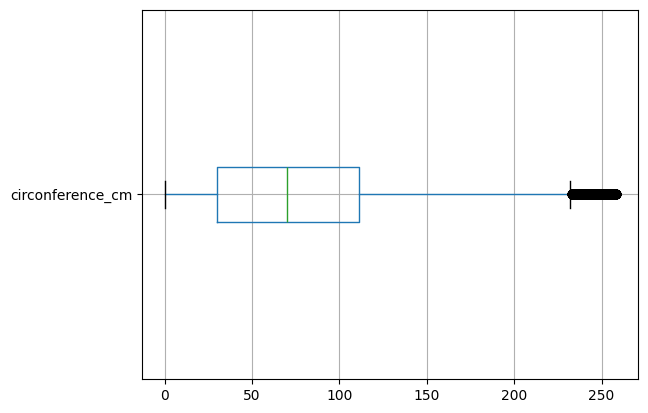

La circonference moyenne d'un arbre est de 76.92cm


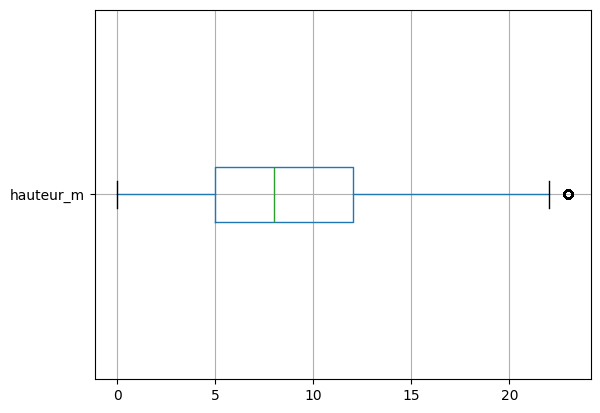

La hauteur moyenne d'un arbre est de 8.04m


In [502]:

data.boxplot(column="circonference_cm", vert=False)
plt.show()
print("La circonference moyenne d'un arbre est de {}cm".format(data["circonference_cm"].mean().round(2)))
data.boxplot(column="hauteur_m", vert=False)
plt.show()
print("La hauteur moyenne d'un arbre est de {}m".format(data["hauteur_m"].mean().round(2)))


Pour y voir plus clair aux données géographiques, nous allons utiliser folium, une librairie nous permettant de créer une carte interactive sur laquelle nous pourrons placer nos arbres.

In [503]:
tree_location_by_district = data.groupby("arrondissement")[["geo_point_2d_a", "geo_point_2d_b"]].mean()
tree_number_by_district = data.groupby("arrondissement").size()
tree_location_by_zone_list = tree_location_by_district.values.tolist()
tree_map = folium.Map((data["geo_point_2d_a"].mean(), data["geo_point_2d_b"].mean()), zoom_start=12)
for zone in range(0, len(tree_location_by_zone_list)):
    district = tree_number_by_district.keys()[zone].capitalize().replace("arrdt", "arrondissement")
    html = """{}<br>
    <center>{} Arbres</center>""".format(district, tree_number_by_district[zone])
    folium.Marker(tree_location_by_zone_list[zone], popup=folium.Popup(html, max_width=200), icon=folium.Icon(color="green", icon_color="white", icon="tree", prefix='fa')).add_to(tree_map)
tree_map

C:\Users\barth\AppData\Local\Temp\ipykernel_26536\3221245201.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  <center>{} Arbres</center>""".format(district, tree_number_by_district[zone])


In [504]:
tree_number_by_district.sort_values(ascending=False)

arrondissement
PARIS 15E ARRDT      17151
PARIS 13E ARRDT      16712
PARIS 16E ARRDT      16403
PARIS 20E ARRDT      15340
PARIS 19E ARRDT      13709
PARIS 12E ARRDT      12600
SEINE-SAINT-DENIS    11570
BOIS DE VINCENNES    11510
PARIS 14E ARRDT      11399
PARIS 17E ARRDT      10762
PARIS 18E ARRDT      10011
PARIS 7E ARRDT        8617
VAL-DE-MARNE          7580
PARIS 8E ARRDT        7245
PARIS 11E ARRDT       5658
HAUTS-DE-SEINE        5298
BOIS DE BOULOGNE      3978
PARIS 10E ARRDT       3385
PARIS 4E ARRDT        2740
PARIS 5E ARRDT        2368
PARIS 6E ARRDT        1764
PARIS 1ER ARRDT       1413
PARIS 3E ARRDT        1209
PARIS 9E ARRDT        1167
PARIS 2E ARRDT         548
dtype: int64

Nous avons affiché sur la carte les arbres et nous avons créé une liste rangeant les arrondissements par le nombre d'arbres qu'ils contiennent. Cela devrait nous donner une idée des arrondissements à privilégier mais nous pouvons aller plus loin. En supposant que plus un arbre est volumineux, plus il prend du temps à entretenir, on pourrait supposé qu'une grosse partie des arbres dans certains arrondissements sont des arbrisseaux, et donc qu'ils prendraient peu de temps à entretenir. Pour illustré ça, nous allons calculer le volume de chaque arbre, puis additionnés le volume de tous les arbres par arrondissement, et enfin, pour y voir plus clair, nous allons en faire un score.

In [505]:
data["volume"] = (data["circonference_cm"] / (2 * pi))**2 * pi * data["hauteur_m"]
data["volume"]
total_volume_by_district = pd.DataFrame(data.groupby("arrondissement")["volume"].sum())
total_volume_by_district["score"] = total_volume_by_district.values / total_volume_by_district.values.max()
total_volume_by_district["score"].sort_values(ascending=False)

arrondissement
PARIS 16E ARRDT      1.000000
PARIS 20E ARRDT      0.905865
PARIS 14E ARRDT      0.698372
PARIS 19E ARRDT      0.664051
BOIS DE VINCENNES    0.616921
PARIS 13E ARRDT      0.608994
PARIS 12E ARRDT      0.551609
PARIS 17E ARRDT      0.550577
PARIS 15E ARRDT      0.534462
PARIS 7E ARRDT       0.533772
PARIS 8E ARRDT       0.528553
PARIS 18E ARRDT      0.492254
SEINE-SAINT-DENIS    0.489045
VAL-DE-MARNE         0.315826
PARIS 11E ARRDT      0.290097
PARIS 10E ARRDT      0.186813
BOIS DE BOULOGNE     0.184674
PARIS 4E ARRDT       0.168172
PARIS 5E ARRDT       0.156774
PARIS 6E ARRDT       0.111298
PARIS 1ER ARRDT      0.071558
PARIS 3E ARRDT       0.060729
PARIS 9E ARRDT       0.060039
HAUTS-DE-SEINE       0.041133
PARIS 2E ARRDT       0.026904
Name: score, dtype: float64

Grâce à cette dernière analyse, nous nous rendons compte que certains arrondissements ont des arbres en moyenne beaucoup moins volumineux que d'autres. L'exemple le plus flagrant est le 15e arrondissement qui est premier dans la liste du nombre d'arbres alors qu'il est douzième dans la liste des volumes.